In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import wandb
import yaml

#from IPython import display as ipd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Configs

In [2]:
class CFG:
    wandb         = True

    #competition   = 'RSNA2023ATD' 
    #_wandb_kernel = 'm-noda'
    #debug         = False
    comment       = 'EfficientNetV12S'
    #exp_name      = 'baseline-v5: ds-v3 + multi_head' 
    
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 0
    display_plot = True

    # device
    #device = "TPU-VM" #or "GPU"

    model_name = 'EfficientNetV2S'

    seed = 123

    folds = 5
    
    # which folds to train
    selected_folds = [0, 1]

    # size of the image
    img_size = [512, 512]

    batch_size = 8
    epochs = 12

    loss      = 'BCE & CCE'
    
    optimizer = 'Adam'

    augment   = True

    # scale-shift-rotate-shear
    transform = 0.90  # transform prob
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 2.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 10.0
    wshift = 10.0

    # flip
    hflip = True
    vflip = True

    # clip
    clip = False

    # lr-scheduler
    scheduler   = 'exp' # cosine

    '''
    # dropout
    drop_prob   = 0.6
    drop_cnt    = 5
    drop_size   = 0.05
    
    # cut-mix-up
    mixup_prob = 0.0
    mixup_alpha = 0.5
    cutmix_prob = 0.0
    cutmix_alpha = 2.5
    '''

    # pixel-augment
    p_pixel_aug = 0.90
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.15
    hue  = 0.05

    # test-time augs
    tta = 1
    
    # target column
    target_col  = [ "bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"] # not using "bowel_healthy" & "extravasation_healthy"


### Seeding for reproducibility

In [3]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


### Prepare train data, test data

In [4]:

train_df = pd.read_csv('./Dataset/train.csv')

test_df = pd.read_csv('./Dataset/test.csv')

### Data split into train and valid

In [5]:
train_df['stratify'] = ''

for col in CFG.target_col:
    train_df['stratify'] += train_df[col].astype(str)

train_df = train_df.reset_index(drop=True)

skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for  fold , (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['stratify'], train_df['patient_id'])):
    train_df.loc[val_idx, 'fold'] = fold

pd.set_option('display.max_rows', 100)
display(train_df.groupby(['fold', 'patient_id']).size())

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


fold  patient_id
0.0   43             59
      263            12
      4331           27
      4639          106
      7411           95
                   ... 
4.0   60993          29
      61742         104
      64194          74
      64256          22
      65456          16
Length: 246, dtype: int64

### Data Augmentation

In [6]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)


# make affine transformation matrix
# https://cs.kwansei.ac.jp/prog1/affine.html
def get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift):
    
    # degrees to radians
    shear = math.pi * shear / 180


    def get_3x3_mat(list):
        return tf.reshape(tf.concat([list], axis=0), [3, 3])
    

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')


    # for shear matrix
    cos = tf.math.cos(shear)
    sin = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one,  sin,  zero,
                                zero, cos,  zero,
                                zero, zero, one])
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    #　return composite transformation
    return K.dot(shear_matrix, K.dot(zoom_matrix, shift_matrix))
    

# apply affine transformation
def transform(image, DIM=CFG.img_size):

    # add padding to align image sizes
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]

    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]

    rotation     = CFG.rot * tf.random.normal([1], dtype='float32')
    rotation     = math.pi * rotation / 180.
    shear        = CFG.shr * tf.random.normal([1], dtype='float32') 
    height_zoom  = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    width_zoom   = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    height_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    width_shift  = CFG.wshift * tf.random.normal([1], dtype='float32')

    # inverse of get_matrix
    # https://daeudaeu.com/reverse-matorix/
    transformation_matrix     =tf.linalg.inv(get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift))
    transformation_matrix_flat=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)

    # apply affine transformation to image
    image=tfa.image.transform(image, transformation_matrix_flat, fill_mode=CFG.fill_mode)

    # rotate image
    image=tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)

    # remove padding
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,4])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,4])
        image = image[pad[0]:-pad[1],:,:]

    # align image sizes
    image = tf.reshape(image, [*DIM, 4])  

    return image


# apply dropout to image
def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, cutout = 5, size = 0.1):

    # boolean to int
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)

    if (P==0) or (cutout==0) or (size==0):
        return image
    
    for c in range(cutout):

        # choose random coordinates
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)

        # determine cutout square
        width = tf.cast(size*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-width//2)
        yb = tf.math.minimum(DIM[0],y+width//2)
        xa = tf.math.maximum(0,x-width//2)
        xb = tf.math.minimum(DIM[1],x+width//2)

        # image after cutout
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,4], dtype = image.dtype) # cutouted square
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,4])

    return image


# apply color augmentation
def ColorAug(image, PROBABILITY):

    if random_float() > PROBABILITY:
        return image
    
    shape = tf.shape(image)

    # separate alpha channel
    image_rgb, image_alpha = image[:, :, :3], image[:, :, 3:]

    # apply random color adjustment to the RGB channels
    # https://qiita.com/Hironsan/items/e20d0c01c95cb2e08b94
    #image_rgb = tf.image.random_hue(image_rgb, CFG.hue) 
    #image_rgb = tf.image.random_saturation(image_rgb, CFG.sat[0], CFG.sat[1])
    image_rgb = tf.image.random_contrast(image_rgb, CFG.cont[0], CFG.cont[1])
    image_rgb = tf.image.random_brightness(image_rgb, CFG.bri)

    # combine the adjusted RGB channels with the original alpha channel
    image = tf.concat([image_rgb, image_alpha], axis=-1)

    image = tf.reshape(image, shape)

    return image

### Data Pipline
1. Reads the PNG file and then decode it to tf.tensor
2. Resizes the image
3. Changes the datatype to float32
4. Cache the data for boosting up the speed
5. Apply augmentations 
6. Split the data into baches

In [7]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):

    def decode_image(path):
        
        file_binary = tf.io.read_file(path)

        if ext == 'png':
            image = tf.image.decode_png(file_binary, channels=4, dtype=tf.uint8)

        else:
            raise ValueError("Image extension not supported")

        image = tf.image.resize(image, target_size, method='bilinear')
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*target_size, 4])

        return image


    def decode_label(label):
        
        label = tf.cast(label, tf.float32)

        return(label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    

    def decode_with_labels(path, label):
        
        return decode_image(path), decode_label(label)
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):

    def augment(image, DIM=dim):

        if random_float() < CFG.transform:
            image = transform(image, DIM=DIM)

        image = tf.image.random_flip_left_right(image) if CFG.hflip else image
        image = tf.image.random_flip_up_down(image) if CFG.vflip else image
        image = ColorAug(image, PROBABILITY=CFG.p_pixel_aug)
        image = tf.clip_by_value(image, 0, 1)  if CFG.clip else image     
        image = tf.reshape(img, [*dim, 4])

    def augment_with_labels(image, label):

        return augment(image), label
    
    return augment_with_labels if with_labels else augment
    

# https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3
def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    # https://tensorflow.classcat.com/2019/03/23/tf20-alpha-guide-data-performance/
    AUTO = tf.data.experimental.AUTOTUNE

    slices = paths if labels is None else (paths, labels)

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds

    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds

    if augment and labels is not None:
        ds = ds.map(lambda image, label: (dropout(image, 
                                               DIM=CFG.img_size, 
                                               PROBABILITY=CFG.drop_prob, 
                                               cutout=CFG.drop_cnt,
                                               size=CFG.drop_size), label),num_parallel_calls=AUTO)

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    
    ds = ds.prefetch(AUTO)

    return ds

### Visualize augmented images

In [8]:
def display_batch(batch, size=2):

    if isinstance(batch, tuple):
        images, targets = batch
    
    else:
        images = batch
        targets = None
    
    targets = tf.concat(targets, axis=-1).numpy()

    plt.figure(figsize=(size*5, 10))

    for image_idx in range(size):
        plt.subplot(1, size, image_idx+1)
        if targets is not None:
            plt.title(f'{targets[image_idx].round(2)}', fontsize=8)
        image = images[image_idx, ]
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show() 

In [9]:
fold = 0
fold_df = train_df[train_df.fold==fold].sample(frac=1.0)
paths = fold_df.image_path.tolist()
labels = fold_df[CFG.target_col].values

ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True, augment=False)

ds = ds.unbatch().batch(20)
batch = next(iter(ds))

2023-10-02 23:05:09.392516: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-02 23:05:09.392572: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2023-10-02 23:05:09.392587: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2023-10-02 23:05:09.392652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-02 23:05:09.392695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


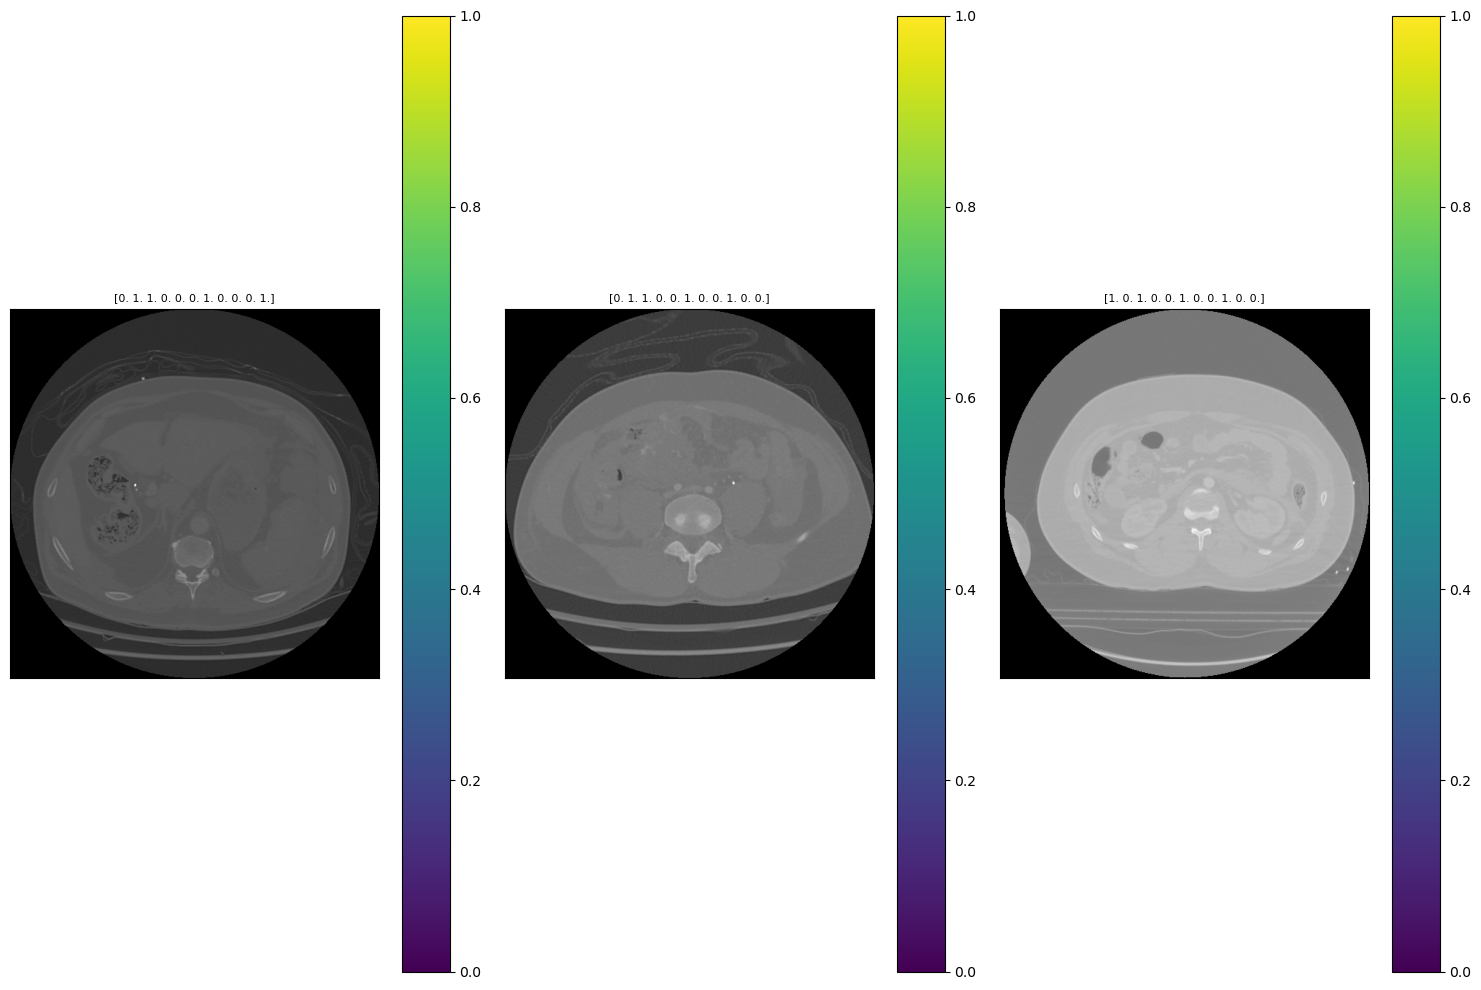

In [10]:
display_batch(batch, 3)

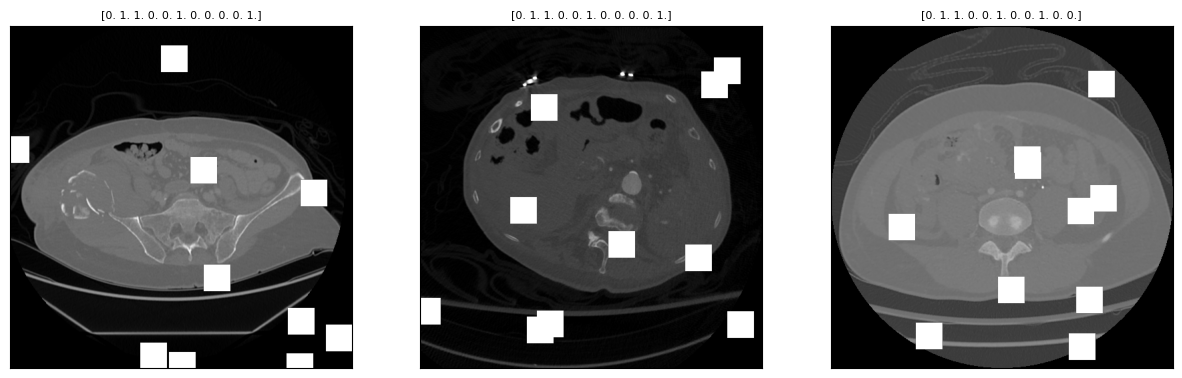

In [11]:
dropout_imgs = tf.map_fn(lambda img: dropout(img,
                DIM=CFG.img_size, 
                PROBABILITY=1.0, 
                cutout=10,
                size=0.08), batch[0])
dropout_targets = batch[1]
display_batch((dropout_imgs, dropout_targets), 3)

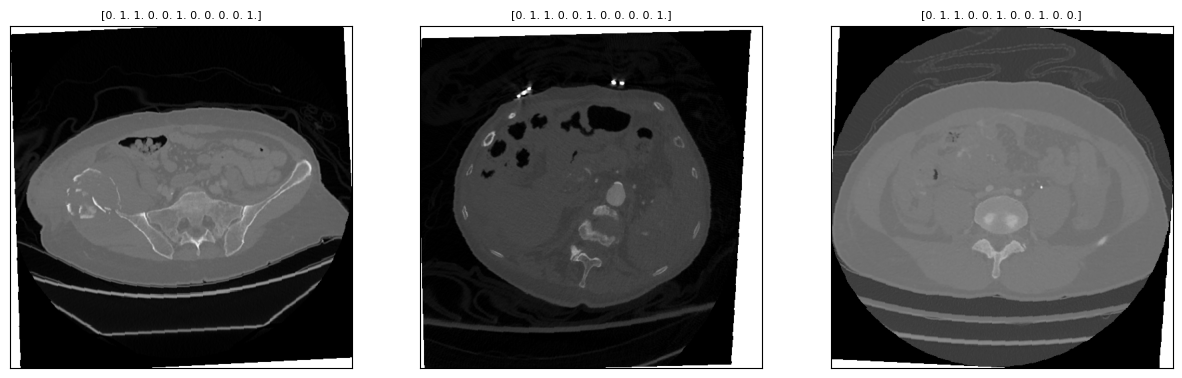

In [12]:
transform_imgs = tf.map_fn(lambda img: transform(img,DIM=CFG.img_size), batch[0])
transform_targets = batch[1]
display_batch((transform_imgs, transform_targets), 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


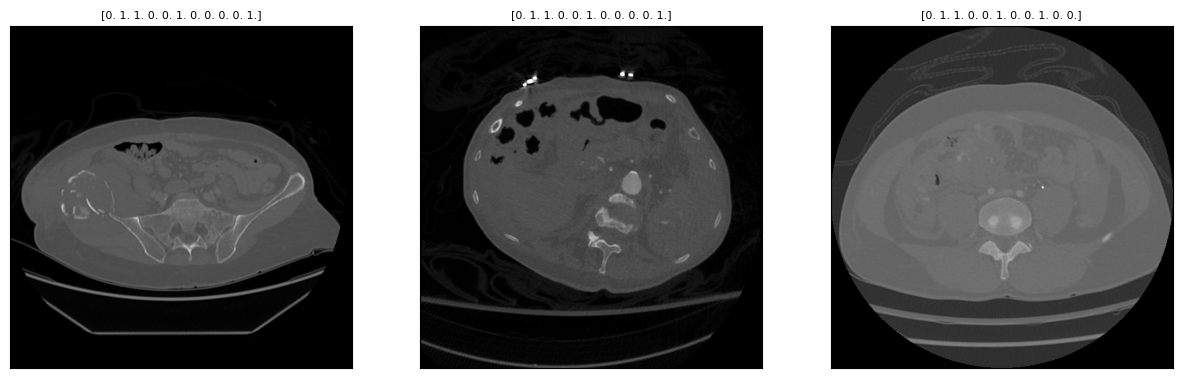

In [13]:
ColorAug_imgs = tf.map_fn(lambda img: ColorAug(img,1.0), batch[0])
ColorAug_targets = batch[1]
display_batch((ColorAug_imgs, ColorAug_targets), 3)

### Build model

In [22]:
from keras_cv_attention_models import efficientnet


def channel_squeezer(x):

    # Expand 4 channels to 32 features
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='gelu')(x)
    # Squeeze 32 features into 3 channels
    x = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='gelu')(x)

    return x


def build_model(model_name=CFG.model_name,
                loss_name=CFG.loss,
                dim=CFG.img_size,
                compile_model=True,
                include_top=False):
    
    # Input layer for 4-channel images
    input = tf.keras.layers.Input(shape=(*dim, 4))
    # Squeeze 4 channels to 3 channels
    x = channel_squeezer(input)

    # Define backbone
    base = getattr(efficientnet, model_name)(input_shape=(*dim,3), pretrained='imagenet', num_classes=0)
    # Data go through backbone
    x = base(x)

    # https://qiita.com/mine820/items/1e49bca6d215ce88594a
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Data go through necks
    x_bowel = tf.keras.layers.Dense(32, activation='silu')(x)
    x_extra = tf.keras.layers.Dense(32, activation='silu')(x)
    x_liver = tf.keras.layers.Dense(32, activation='silu')(x)
    x_kidney = tf.keras.layers.Dense(32, activation='silu')(x)
    x_spleen = tf.keras.layers.Dense(32, activation='silu')(x)

    # Data go through heads
    # Use sigmoid for binary class
    # Use softmax for multi class
    out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

    # Output
    output = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    model = tf.keras.Model(inputs=input, outputs=output)

    if compile_model:

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

        # 'tfa.losses.SigmoidFocalCrossEntropy' also can be used for bowel and extra
        # https://developers.microad.co.jp/entry/2021/04/26/060000
        loss = {'bowel':tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
                'extra':tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
                'liver':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                'kidney':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                'spleen':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)}

        metrics = {'bowel':['accuracy'],
                   'extra':['accuracy'],
                   'liver':['accuracy'],
                   'kidney':['accuracy'],
                   'spleen':['accuracy']}
        
        model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=metrics)
        
    return model

In [23]:
tmp = build_model(CFG.model_name, dim=CFG.img_size, compile_model=True)
tmp.summary() 

87846816/87846816 [==============================] - 39s 0us/step
>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-s-imagenet.h5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 4)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 512, 512, 32)         1184      ['input_2[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 512, 512, 3)          867       ['conv2d_2[0][0]']            
                                                                                                  
 efficientnet_v2-s (Functio  (None, 16, 16, 1280)         2033136   ['conv2d_3[0][0]']            
 nal)                                                     0                                   

In [ ]:
wandb.login()
os.environ["WANDB_NOTEBOOK_NAME"] = "RSNA2023ATDEfficientnet"


def wandb_init(fold):

    config = {key:value for key,value in dict(vars(CFG)).items()}
    config.update({"fold":int(fold)})

    run = wandb.init(project="RSNA2023ATDEfficientnet", 
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     config=config,
                     group=CFG.comment}
    
    return run


def log_wandb(fold):

    wandb.log({'best_acc': best_acc,
               'best_loss': best_loss,
               'best_epoch': best_epoch+1,
               'best_acc_bowel': best_acc_bowel,
               'best_acc_extra': best_acc_extra,
               'best_acc_liver': best_acc_liver,
               'best_acc_kidney': best_acc_kidney,
               'best_acc_spleen': best_acc_spleen})